# Visualize the UMAP feature spaces

We calculated UMAP coordindates for four feature spaces:

1. All features
2. Feature selected features by traditional methods
3. Bortezomib signature features
4. All features except bortezomib signature features

We create a figure here to demonstrate qualitatively the differences.

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(cowplot))

In [2]:
# Output file
output_file <- file.path("figures", "umap_feature_comparison.png")

In [3]:
# Load singscore results
singscore_file <- file.path("../3.resistance-signature/results/singscore/singscore_resultsbortezomib.tsv.gz")

singscore_df <- readr::read_tsv(
    singscore_file,
    col_types = readr::cols(
        Metadata_Plate = "c",
        Metadata_Well = "c",
        Metadata_batch = "c",
        TotalScore = "d"
    )
) %>%
    dplyr::select(Metadata_Plate, Metadata_Well, Metadata_batch, Metadata_dataset, TotalScore)

print(dim(singscore_df))
head(singscore_df, 3)

[1] 525   5


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_dataset,TotalScore
<chr>,<chr>,<chr>,<chr>,<dbl>
219907,B02,2021_03_03_Batch12,bortezomib,-0.15194809
219907,B03,2021_03_03_Batch12,bortezomib,-0.03125574
219907,B04,2021_03_03_Batch12,bortezomib,0.00999497


In [4]:
# Load umap summary
umap_file <- file.path("results", "umap_feature_summary.tsv.gz")
umap_df <- readr::read_tsv(
    umap_file,
    col_types = readr::cols(
        Metadata_Plate = "c",
        Metadata_Well = "c",
        Metadata_batch = "c"
    )
    )%>%
    dplyr::inner_join(
        singscore_df,
        by = c("Metadata_Plate", "Metadata_Well", "Metadata_batch"),
        relationship = "many-to-many"
    )

umap_df$Metadata_umap_category <- dplyr::recode(
    umap_df$Metadata_umap_category,
    all_features = "All features",
    feature_selected = "Feature selected",
    all_except_bortezomib_signature_features = "All except BZ",
    bortezomib_signature_features = "BZ features"
)

umap_df$Metadata_umap_category <- factor(
    umap_df$Metadata_umap_category, levels = c("All features", "Feature selected", "All except BZ", "BZ features")
)

print(dim(umap_df))
head(umap_df, 3)

[1] 2116   21


umap_0,umap_1,Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,⋯,Metadata_plate_filename,Metadata_plate_map_name,Metadata_time_to_adhere,Metadata_treatment,Metadata_treatment_shorthand_from_plate_graph,Metadata_treatment_time,Metadata_clone_type,Metadata_umap_category,Metadata_dataset,TotalScore
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>,<dbl>
5.674817,3.613967,219901,B02,2021_03_03_Batch14,3404,2.5x10^3 cells/well,1,WT_parental,20210219,⋯,NA,219901,48 hr,0.1% DMSO,1,4 hr,wildtype,All features,bortezomib,0.04934260
10.290071,2.441329,219901,B03,2021_03_03_Batch14,1726,2.5x10^3 cells/well,2,CloneA,20210219,⋯,NA,219901,48 hr,0.1% DMSO,1,4 hr,resistant,All features,bortezomib,-0.02464514
10.387980,1.467352,219901,B04,2021_03_03_Batch14,2423,2.5x10^3 cells/well,3,CloneE,20210219,⋯,NA,219901,48 hr,0.1% DMSO,1,4 hr,resistant,All features,bortezomib,0.01294887


In [5]:
colnames(umap_df)

[1] "umap_0"                                       
 [2] "umap_1"                                       
 [3] "Metadata_Plate"                               
 [4] "Metadata_Well"                                
 [5] "Metadata_batch"                               
 [6] "Metadata_cell_count"                          
 [7] "Metadata_cell_density"                        
 [8] "Metadata_celltype_shorthand_from_plate_graph" 
 [9] "Metadata_clone_number"                        
[10] "Metadata_date"                                
[11] "Metadata_plate_ID"                            
[12] "Metadata_plate_filename"                      
[13] "Metadata_plate_map_name"                      
[14] "Metadata_time_to_adhere"                      
[15] "Metadata_treatment"                           
[16] "Metadata_treatment_shorthand_from_plate_graph"
[17] "Metadata_treatment_time"                      
[18] "Metadata_clone_type"                          
[19] "Metadata_umap_category"                       
[20] "Metadata_dataset"                             
[21] "TotalScore"

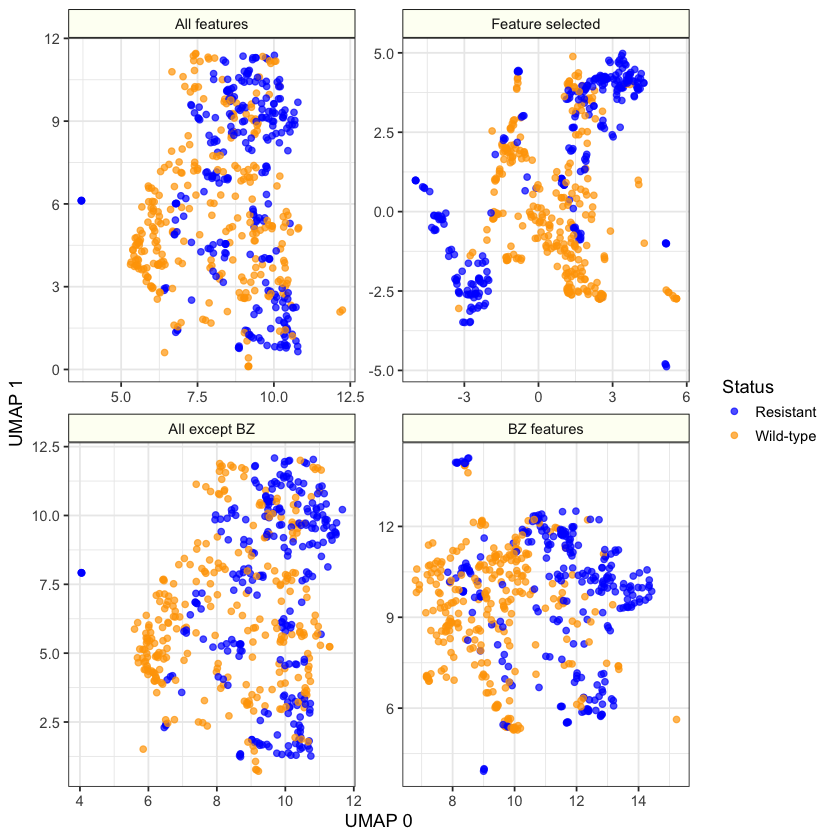

In [6]:
panel_status_gg <- (
    ggplot(
        umap_df,
        aes(x = umap_0, y = umap_1)
    )
    + geom_point(aes(color = Metadata_clone_type), alpha = 0.7)
    + facet_wrap("~Metadata_umap_category", scales="free")
    + theme_bw()
    + labs(x = "UMAP 0", y = "UMAP 1")
    + theme(
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
    + scale_color_manual(
        name = "Status",
        labels = c("resistant" = "Resistant", "wildtype" = "Wild-type"),
        values = c("resistant" = "blue", "wildtype" = "orange")
    )
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
)

panel_status_gg

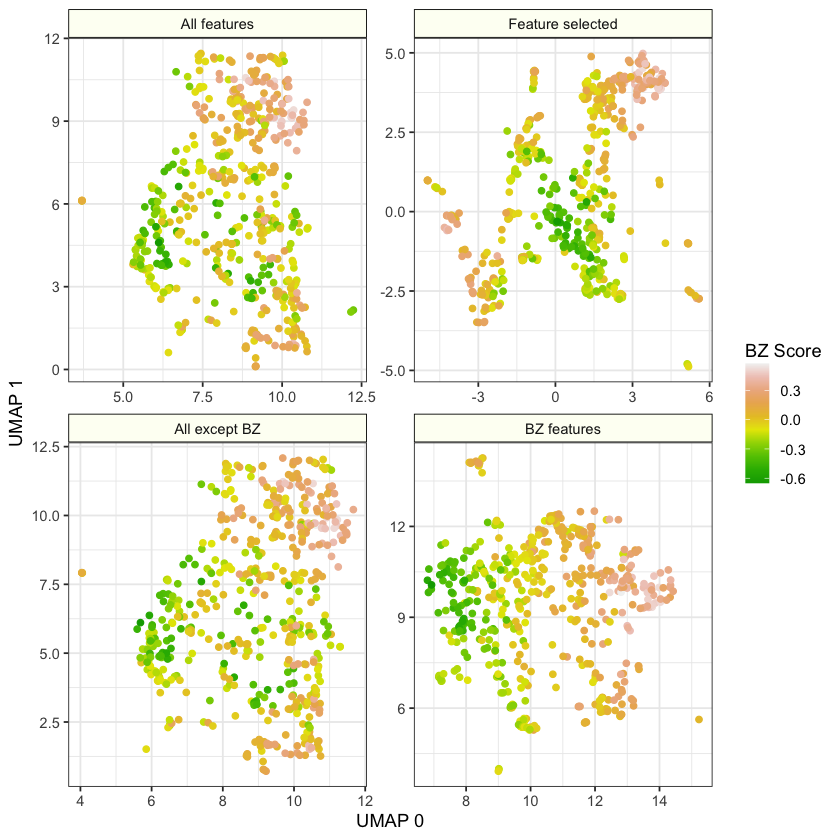

In [7]:
panel_score_gg <- (
    ggplot(
        umap_df,
        aes(x = umap_0, y = umap_1)
    )
    + geom_point(aes(color = TotalScore))
    + facet_wrap("~Metadata_umap_category", scales="free")
    + theme_bw()
    + labs(x = "UMAP 0", y = "UMAP 1")
    + theme(
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        )
    )
    + scale_colour_gradientn(
        name = "BZ Score",
        colors = terrain.colors(10)
    )
    # Decrease spacing in legend
    + theme(
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
)

panel_score_gg

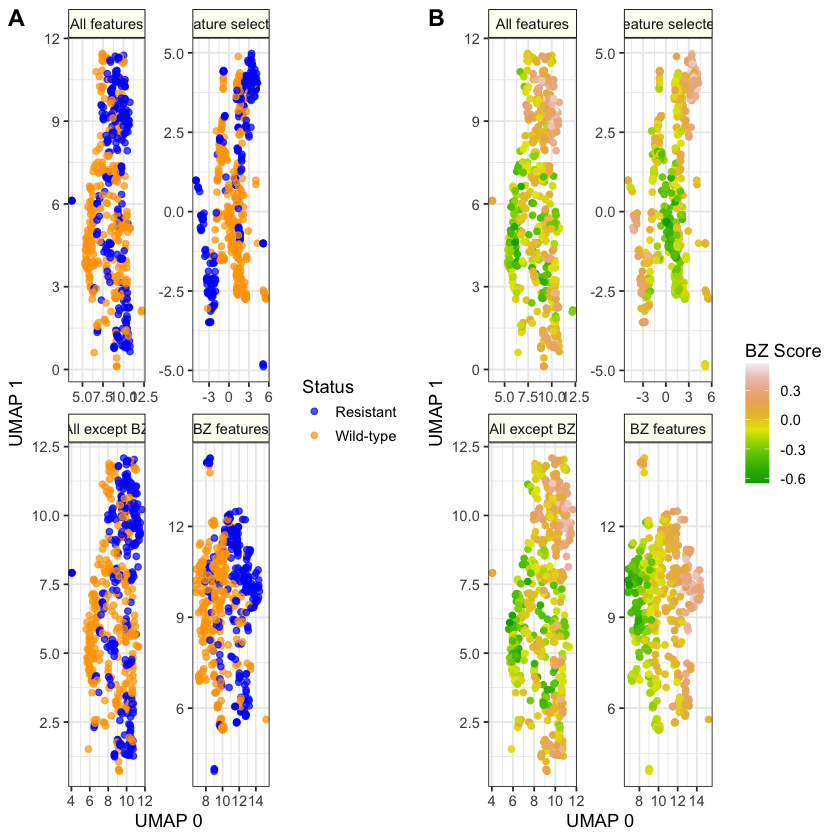

In [8]:
supplementary_umap_gg <- cowplot::plot_grid(
    panel_status_gg,
    panel_score_gg,
    ncol = 2,
    labels = c("A", "B")
)

ggsave(output_file, supplementary_umap_gg, height = 4, width = 10, dpi = 500)

supplementary_umap_gg